> This file is the webpage available [here](https://mia_jinns.gitlab.io/jinns/Notebooks/ODE/systems_biology_informed_neural_network.html). We added some comments to facilitate the comprehension.

# Systems Biology Informed Neural Network

We aim to reimplement the SBINN from the article _Systems Biology: Identifiability analysis and parameter
identification via systems-biology informed neural networks_, M. Daneker et al., 2023, [link](https://arxiv.org/pdf/2202.01723.pdf). This is a `jinns` adaptation of the [code](https://github.com/lu-group/sbinn) acoompanying the article. Results are discussed [here](https://github.com/lu-group/sbinn/issues/4).

In [90]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Float64 and GPU settings

In [91]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [92]:
import jinns

Import other dependencies

In [93]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
import numpy as np
import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

# Data simulation (train data)

{'kappa_tild': 0.030940000000000002, 'Tr1_tild': 11.363636363636365, 'Tr2_tild': 50.0, 'Tc_tild': 0.7861872559674757, 'Ta_tild': 5.723443223443223, 'lambda_tild': 11.041333333333334}


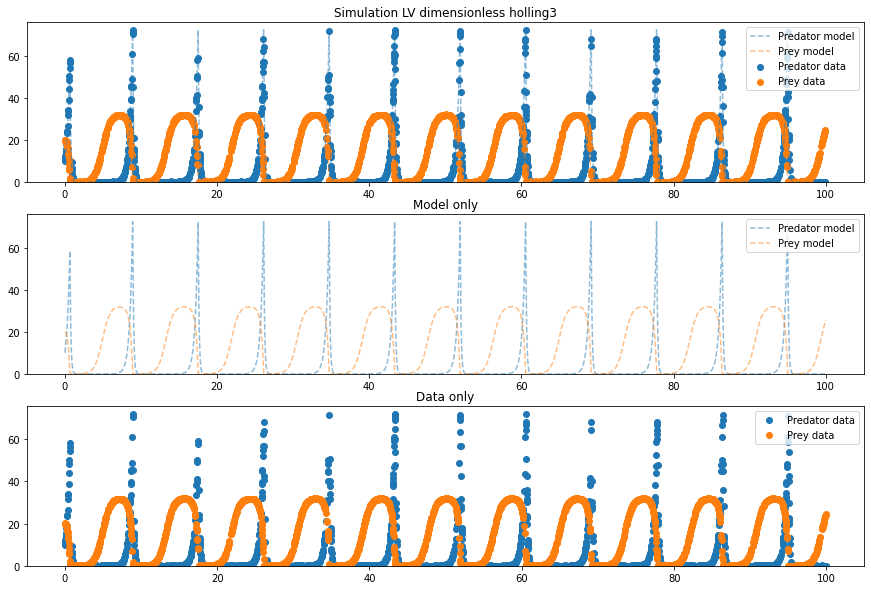

In [94]:
file_data = None

if file_data == None:
    
    from models_and_data_gen_LV import data_gen_LV2pop_adim, eco_to_dimless

    func_rep = 'holling3'

    eco_params = {
        "a1": 0.088,
        "a2": 0.020,
        "e": 1,
        "c": 0.96,
        "K": 0.034,
        "S": 0.12,
        "xR1": 0.12,
        "xR2": 0.91
    }
    eco_params["b"] = eco_params["e"] / eco_params["S"]
    if func_rep == 'holling1' or func_rep == 'holling1_sat':
        eco_params["a"] = 0.086
    elif func_rep == 'holling2':
        eco_params["a"] = 0.13
    elif func_rep == 'holling3':
        eco_params["a"] = 1.6

    dimless_params = eco_to_dimless(eco_params, func_rep=func_rep)

    print(dimless_params)

    tmax = 100
    x1_tild_ini, x2_tild_ini = 10, 20 # Predator, Prey

    plt.figure(figsize=(15, 10))
    plt.subplot(3, 1, 1)
    data = data_gen_LV2pop_adim(dimless_params, tmax, [x1_tild_ini, x2_tild_ini], func_rep=func_rep, 
                                nbpoint=3000, noise_intensity=.1, rd_seed=123, plot_data=True)
    plt.subplot(3, 1, 2)
    data.plot_initial_data(elements_to_plot=["model"], title="Model only")
    plt.subplot(3, 1, 3)
    data.plot_initial_data(elements_to_plot=["data"], title="Data only")

    data.export_data()
    file_data = data.file_data


In [95]:
data = np.loadtxt(file_data)
data_t = data[:, 0]
data_X = data[:, 1:]

tmax_data = max(data_t)
n_points = data.shape[0] # = 3000 for now

Feature layer (let as it is for now...)

In [96]:
def feature_transform(t, params):
    """
    t and params are mandatory parameters for an input_transform function in jinns
    """
    # t = 0.01 * t
    return jnp.concatenate(
        [t],
        axis=0
    )


In [97]:
def output_transform (t , y ) :
    # The scaling values are [1 ,1]
    return jnp.array([1, 1]) * y


In [98]:
# eqx_list = [
#     [eqx.nn.Linear, 6, 128],
#     [jax.nn.swish],
#     [eqx.nn.Linear, 128, 128],
#     [jax.nn.swish],
#     [eqx.nn.Linear, 128, 128],
#     [jax.nn.swish],
#     [eqx.nn.Linear, 128, 128],
#     [jax.nn.swish],
#     [eqx.nn.Linear, 128, 6]
# ]

eqx_list = [
    [eqx.nn.Linear, 1, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 2]
]

key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "ODE", input_transform=feature_transform, output_transform=output_transform)

In [99]:
init_nn_params = u.init_params()

Create a DataGenerator object

In [100]:
n = 2048
batch_size = 2048
method = 'uniform'
tmin = 0
tmax = tmax_data

Tmax = 1
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE(
    subkey,
    n,
    tmin,
    tmax,
    batch_size,                    
    method=method,
#     rar_parameters=rar_parameters,
#     nt_start=n_start
)

## Observations to guide the solution

In [101]:
n = 1800
key, subkey = random.split(key)
idx = jnp.append(
    jax.random.choice(subkey, jnp.arange(1, n - 1), shape=(n // 5,), replace=False),
    jnp.array([0, n - 1])
)

observed_t = data_t[idx].squeeze() / Tmax
observed_x2 = data_X[idx, 1]
observed_X = observed_x2

# feature_transform(observed_t, observed_X)

## Loss construction and model parameters

A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary.

__Note__ that `nn_params` and `eq_params` must always be top level keys but can be nested dictionaries.

__Note__ that the keys of the sub dictionaries `nn_params` and `eq_params` (here `str(i)`) can differ !

In [102]:
# initiate parameters dictionary
init_params = {}

init_params["nn_params"] = init_nn_params

def get_variable(v, var):
    low, up = v * 0.2, v * 1.8
    l = (up - low) / 2
    v1 = l * jnp.tanh(var) + l + low
    return v1


kappa_tild_ = 0
Tr1_tild_ = 0
Tr2_tild_ = 0
Tc_tild_ = 0
Ta_tild_ = 0
lambda_tild_ = 0

true_dimless_params = {'kappa_tild': 0.030940000000000002, 
                       'Tr1_tild': 11.363636363636365, 
                       'Tr2_tild': 50.0, 
                       'Tc_tild': 0.7861872559674757, 
                       'Ta_tild': 5.723443223443223, 
                       'lambda_tild': 11.041333333333334}



true_dimless_params['Tr1_tild'] + np.random.normal(0, 0.1)
true_dimless_params['Tr2_tild'] + np.random.normal(0, 0.1)
true_dimless_params['Tc_tild'] + np.random.normal(0, 0.01)
true_dimless_params['Ta_tild'] + np.random.normal(0, 0.1)
true_dimless_params['lambda_tild'] + np.random.normal(0, 0.1)
init_params["eq_params"] = {
    "kappa_tild":get_variable(
        true_dimless_params['kappa_tild'] + np.random.normal(0, 0.001), 
        kappa_tild_),
    "Tr1_tild":get_variable(
        true_dimless_params['Tr1_tild'] + np.random.normal(0, 0.1), 
        Tr1_tild_),
    "Tr2_tild":get_variable(
        true_dimless_params['Tr2_tild'] + np.random.normal(0, 0.1), 
        Tr2_tild_),
    "Tc_tild":get_variable(
        true_dimless_params['Tc_tild'] + np.random.normal(0, 0.01), 
        Tc_tild_),
    "Ta_tild":get_variable(
        true_dimless_params['Ta_tild'] + np.random.normal(0, 0.1), 
        Ta_tild_),
    "lambda_tild":get_variable(
        true_dimless_params['lambda_tild'] + np.random.normal(0, 0.1), 
        lambda_tild_)
}

In [103]:
from jinns.loss._DynamicLossAbstract import ODE
from models_and_data_gen_LV import mod_dimless_LV_2pop

Func_rep = 'holling3'

class sbinn(ODE):
    def __init__(self, Tmax=1):
        super().__init__(Tmax)
    
    def evaluate(self, t, u, params):
        out = u(t, params)
        x1_tild = out[0]
        x2_tild = out[1]
        eq_params = params["eq_params"]
        # kappa_tild = eq_params["kappa_tild"]
        # Tr1_tild = eq_params["Tr1_tild"]
        # Tr2_tild = eq_params["Tr2_tild"]
        # Tc_tild = eq_params["Tc_tild"]
        # Ta_tild = eq_params["Ta_tild"]
        # lambda_tild = eq_params["lambda_tild"]

        dx1_tild_dt = jax.grad(lambda t: u(t, params)[0], 0)
        dx2_tild_dt = jax.grad(lambda t: u(t, params)[1], 0)
        
        return jnp.stack([
            dx1_tild_dt(t) + self.Tmax * (- mod_dimless_LV_2pop([x1_tild, x2_tild], eq_params, func_pred=Func_rep, Tref=1)[0] ),
            dx2_tild_dt(t) + self.Tmax * (- mod_dimless_LV_2pop([x1_tild, x2_tild], eq_params, func_pred=Func_rep, Tref=1)[1] )
            ],
            axis=-1
        )

sbinn_dynamic_loss = sbinn(Tmax=Tmax)

print(print(u(jnp.array(3), init_nn_params)))
print(sbinn_dynamic_loss.evaluate(jnp.array(0.2), u, init_params))
print(sbinn_dynamic_loss.evaluate(jnp.array(0.3), u, init_params))

test_other_params = init_params
test_other_params['eq_params'] = true_dimless_params
print(sbinn_dynamic_loss.evaluate(jnp.array(0.2), u, test_other_params))
print(sbinn_dynamic_loss.evaluate(jnp.array(0.3), u, test_other_params))


[ 0.15697572 -0.04794278]
None
[-0.03034632  0.06203428]
[-0.02245656  0.06078656]
[-0.0303742   0.06204231]
[-0.02248416  0.06079441]


In [104]:
loss_weights = {
    "dyn_loss":1, "initial_condition":0, "observations": 0
}

loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=sbinn_dynamic_loss,
    obs_batch=[observed_t, observed_X],
    obs_slice=jnp.s_[2]
)


In [105]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    train_data.get_batch()
)
l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 0.0004644487635232508
Individual losses: {'dyn_loss': '0.00', 'initial_condition': '0.00', 'observations': '0.00'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [106]:
params = init_params

In [107]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)

In [108]:
n_iter = int(20000)

In [109]:
key, subkey = random.split(key)

In [110]:
params, total_loss_list, loss_by_term_dict, train_data, loss, opt_state, _ = jinns.solve(
    n_iter=n_iter,
    init_params=params,
    data=train_data,
    loss=loss,
    optimizer=tx,
)

Iteration 0: loss value = 0.00035484554246068


  0%|          | 0/20000 [00:00<?, ?it/s]

Iteration 1000: loss value = 2.556187261859577e-08
Iteration 2000: loss value = 4.327331826203817e-09
Iteration 3000: loss value = 1.4302954376432808e-09
Iteration 4000: loss value = 5.760487642447742e-10
Iteration 5000: loss value = 3.297996875595288e-10
Iteration 6000: loss value = 1.2623013745383105e-09
Iteration 7000: loss value = 2.423422296171651e-10
Iteration 8000: loss value = 1.9628361436208053e-10
Iteration 9000: loss value = 1.6595552709830486e-10
Iteration 10000: loss value = 1.566894392013296e-10
Iteration 11000: loss value = 1.1023270490850834e-10
Iteration 12000: loss value = 9.330051314870857e-11
Iteration 13000: loss value = 7.859197320714273e-11
Iteration 14000: loss value = 6.400842356146796e-11
Iteration 15000: loss value = 1.2522816117410684e-10
Iteration 16000: loss value = 5.241687639490067e-11
Iteration 17000: loss value = 6.671518892886752e-09
Iteration 18000: loss value = 7.103982679890208e-11
Iteration 19000: loss value = 2.6449700207820115e-09
Iteration 2000

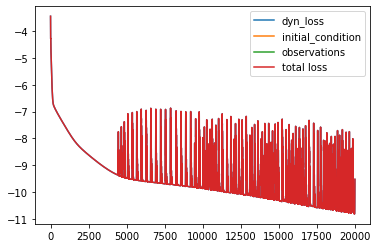

{'Ta_tild': Array(5.723443, dtype=float32), 'Tc_tild': Array(0.78618723, dtype=float32), 'Tr1_tild': Array(11.363636, dtype=float32), 'Tr2_tild': Array(50., dtype=float32), 'kappa_tild': Array(0.03094, dtype=float32), 'lambda_tild': Array(11.041333, dtype=float32)}


In [111]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();
# print(jnp.log10(loss_by_term_dict["observations"]))
print(params["eq_params"])

Following the code provided by the authors, we change the learning weights before continue the optimization further

In [112]:
# loss.loss_weights = {
#     "dyn_loss":jnp.array([1, 1, 1e-2, 1, 1, 1]), "initial_condition":1, "observations": 1e-2
# }

# n_iter = 100000
# params, total_loss_list, loss_by_term_dict, train_data, loss, opt_state, _ = jinns.solve(
#     n_iter=n_iter,
#     init_params=params,
#     data=train_data,
#     loss=loss,
#     optimizer=tx,
# )

## Results

Plot the loss values

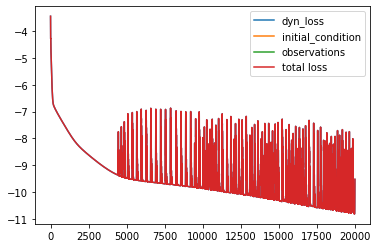

In [113]:
for loss_name, loss_values in loss_by_term_dict.items():
#     if loss_name == "dyn_loss":
        plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the ODE solutions learned by the PINN

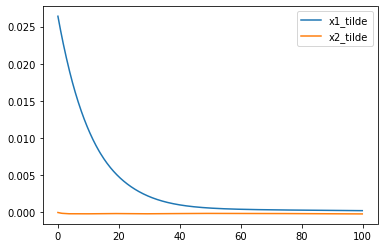

In [114]:
u_est_x1_tilde = vmap(lambda t:u(t, params["nn_params"])[0], (0), 0)
u_est_x2_tilde = vmap(lambda t:u(t, params["nn_params"])[1], (0), 0)

key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(subkey, n, tmin, tmax, batch_size, method)


u_est_x1_tilde = vmap(lambda t:u(t, params["nn_params"])[0], (0), 0)
plt.plot(val_data.times.sort(axis=0) * Tmax, 
         u_est_x1_tilde(val_data.times.sort(axis=0)), label="x1_tilde")
plt.plot(val_data.times.sort(axis=0) * Tmax, 
         u_est_x2_tilde(val_data.times.sort(axis=0)), label="x2_tilde")
plt.legend()
plt.show();


## Compare with the scipy solver

In [22]:
import numpy as np
from scipy.integrate import odeint


def glucose_insulin_model(
    t,
    meal_t,
    meal_q,
    Vp=3,
    Vi=11,
    Vg=10,
    E=0.2,
    tp=6,
    ti=100,
    td=12,
    k=1 / 120,
    Rm=209,
    a1=6.6,
    C1=300,
    C2=144,
    C3=100,
    C4=80,
    C5=26,
    Ub=72,
    U0=4,
    Um=90,
    Rg=180,
    alpha=7.5,
    beta=1.772,
):
    def func(y, t):
        f1 = Rm / (1 + np.exp(-y[2] / Vg / C1 + a1))
        f2 = Ub * (1 - np.exp(-y[2] / Vg / C2))
        kappa = (1 / Vi + 1 / E / ti) / C4
        f3 = (U0 + Um / (1 + (kappa * y[1]) ** (-beta))) / Vg / C3
        f4 = Rg / (1 + np.exp(alpha * (y[5] / Vp / C5 - 1)))
        IG = np.sum(
            meal_q * k * np.exp(Tmax * k * (meal_t - t)) * np.heaviside(Tmax * (t - meal_t), 0.5)
        )
        tmp = E * (y[0] / Vp - y[1] / Vi)
        return [
            Tmax * (f1 - tmp - y[0] / tp),
            Tmax * (tmp - y[1] / ti),
           Tmax * ( f4 + IG - f2 - f3 * y[2]),
            Tmax * ((y[0] - y[3]) / td),
            Tmax * ((y[3] - y[4]) / td),
            Tmax * ((y[4] - y[5]) / td),
        ]

    Vp0, Vi0, Vg0 = 3, 11, 10
    y0 = [12 * Vp0, 4 * Vi0, 110 * Vg0 ** 2, 0, 0, 0]
    return odeint(func, y0, t)


meal_t = np.array([300, 650, 1100, 2000]) / Tmax
meal_q = np.array([60e3, 40e3, 50e3, 100e3])
t = np.arange(0, 1800, 1)[:, None] / Tmax
y = glucose_insulin_model(np.ravel(t), meal_t, meal_q)

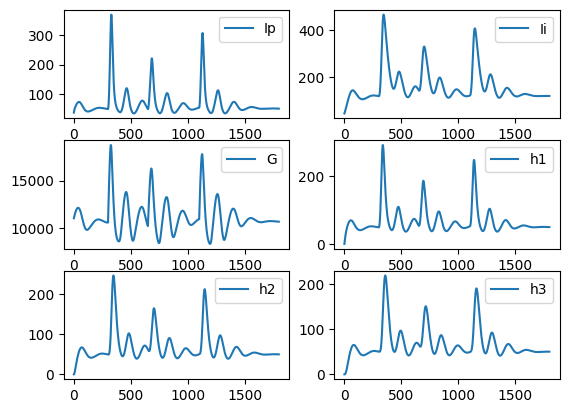

In [23]:
fig, axes = plt.subplots(3, 2)
labels = ["Ip", "Ii", "G", "h1", "h2", "h3"]
for i in range(3):
    for j in range(2):
        idx = jnp.ravel_multi_index((i, j), (3, 2))
        axes[i, j].plot(t * Tmax, y[:, idx], label=labels[idx])
        axes[i, j].legend()

## Alternative approach in `jinns`

Here, we briefly illustrate how to solve the problem using $6$ different PINNs (different sets of parameters but **same architecture** and $6$ Dynamic Losses to estimate the solution.

1) The network architecture changes and we also need to adapt the `output_transform`:

In [24]:
eqx_list = [
    [eqx.nn.Linear, 6, 20],
    [jax.nn.swish],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.swish],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.swish],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.swish],
    [eqx.nn.Linear, 20, 1]
]

def output_transform(t, y, id_component):
    idx = 1799
    t = t.squeeze() * 1
    k = (data_y[idx, id_component] - data_y[0, id_component]) / (data_t[idx] - data_t[0])
    b = (data_t[idx] * data_y[0, id_component] - data_t[0] * data_y[idx, id_component]) / (
        data_t[idx] - data_t[0]
    )
    linear = k.squeeze() * t + b.squeeze()
    factor = jnp.tanh(t) * jnp.tanh(idx - t)

    return linear + factor * jnp.array([1, 1, 1e2, 1, 1, 1])[id_component] * y

2) The network initialisation changes:

In [26]:
from functools import partial
init_nn_params_list = []
nn_list = []
for i in range(6):
    key, subkey = random.split(key)
    u = jinns.utils.create_PINN(
        subkey,
        eqx_list,
        "ODE",
        0,
        input_transform=feature_transform,
        output_transform=partial(output_transform, id_component=i)
    )
    init_nn_params = u.init_params()
    init_nn_params_list.append(init_nn_params)
    nn_list.append(u)

3. The dictionary of parameters changes only for `"nn_params"`:

In [28]:
init_params = {}
nn_keys = ["Ip", "Ii", "G", "h1", "h2", "h3"]
init_params["nn_params"] = {
    nn_keys[i]: init_nn_params_list[i]
    for i in range(6)
}

4. Now we define 6 different Dynamic Losses

In [29]:
from jinns.loss._DynamicLossAbstract import ODE

        
class SBINN_Ip(ODE):
    def __init__(self, Tmax=1, derivatives="nn_params"):
        super().__init__(Tmax, derivatives)
    
    def evaluate(self, t, u_dict, params_dict):
        nn_params, eq_params = self.set_stop_gradient(params_dict)
                        
        Ip, dIp_dt = jax.value_and_grad(lambda t: u_dict["Ip"](t, nn_params["Ip"], eq_params), 0)(t)
        Ii = u_dict["Ii"](t, nn_params["Ii"], eq_params)
        G = u_dict["G"](t, nn_params["G"], eq_params)
        
        f1 = eq_params["Rm"] * jax.nn.sigmoid(G / (eq_params["Vg"] * eq_params["C1"]) - eq_params["a1"])
        tmp = eq_params["E"] * (Ip / eq_params["Vp"] - Ii / eq_params["Vi"])
        

        return dIp_dt + self.Tmax * (- (f1 - tmp - Ip / eq_params["tp"]))

sbinn_Ip = SBINN_Ip(Tmax=Tmax)

        
class SBINN_Ii(ODE):
    def __init__(self, Tmax=1, derivatives="nn_params"):
        super().__init__(Tmax, derivatives)
    
    def evaluate(self, t, u_dict, params_dict):
        nn_params, eq_params = self.set_stop_gradient(params_dict)
                        
        Ii, dIi_dt = jax.value_and_grad(lambda t: u_dict["Ii"](t, nn_params["Ii"], eq_params), 0)(t)
        Ip = u_dict["Ip"](t, nn_params["Ip"], eq_params)

        tmp = eq_params["E"] * (Ip / eq_params["Vp"] - Ii / eq_params["Vi"])
        

        return dIi_dt + self.Tmax * ( - (tmp - Ii / eq_params["ti"]))

sbinn_Ii = SBINN_Ii(Tmax=Tmax)

        
class SBINN_G(ODE):
    def __init__(self, Tmax=1, derivatives="nn_params"):
        super().__init__(Tmax, derivatives)
    
    def evaluate(self, t, u_dict, params_dict):
        nn_params, eq_params = self.set_stop_gradient(params_dict)
                        
        G, dG_dt = jax.value_and_grad(lambda t: u_dict["G"](t, nn_params["G"], eq_params), 0)(t)
        Ii = u_dict["Ii"](t, nn_params["Ii"], eq_params)
        h3 = u_dict["h3"](t, nn_params["h3"], eq_params)

        
        f2 = eq_params["Ub"] * (1 - jnp.exp(-G / (eq_params["Vg"] * eq_params["C2"])))
        kappa = (1 / eq_params["Vi"] + 1 / (eq_params["E"] * eq_params["ti"])) / eq_params["C4"]
        f3 = (
            eq_params["U0"]
            + eq_params["Um"]
            / (1 + jnp.power(jnp.maximum(kappa * Ii, (1e-3)), -eq_params["beta"]))
        ) / (eq_params["Vg"] * eq_params["C3"])
        f4 = eq_params["Rg"] * jax.nn.sigmoid(eq_params["alpha"] * (1 - h3 / (eq_params["Vp"] * eq_params["C5"])))
        dt = Tmax * (t - eq_params["meal_t"])
        IG = jnp.sum(
            0.5
            * eq_params["meal_q"]
            * eq_params["k"]
            * jnp.exp(-eq_params["k"] * dt)
            * (jnp.sign(dt) + 1)
        )

        return dG_dt + self.Tmax * ( - (f4 + IG - f2 - f3 * G))

sbinn_G = SBINN_G(Tmax=Tmax)

        
class SBINN_h1(ODE):
    def __init__(self, Tmax=1, derivatives="nn_params"):
        super().__init__(Tmax, derivatives)
    
    def evaluate(self, t, u_dict, params_dict):
        nn_params, eq_params = self.set_stop_gradient(params_dict)
                        
        h1, dh1_dt = jax.value_and_grad(lambda t: u_dict["h1"](t, nn_params["h1"], eq_params), 0)(t)
        Ip = u_dict["Ip"](t, nn_params["Ip"], eq_params)


        return dh1_dt + self.Tmax * ( - (Ip - h1) / eq_params["td"])

sbinn_h1 = SBINN_h1(Tmax=Tmax)

class SBINN_h2(ODE):
    def __init__(self, Tmax=1, derivatives="nn_params"):
        super().__init__(Tmax, derivatives)
    
    def evaluate(self, t, u_dict, params_dict):
        nn_params, eq_params = self.set_stop_gradient(params_dict)
                        
        h2, dh2_dt = jax.value_and_grad(lambda t: u_dict["h2"](t, nn_params["h2"], eq_params), 0)(t)
        h1 = u_dict["h1"](t, nn_params["h1"], eq_params)

        return dh2_dt + self.Tmax * ( - (h1 - h2) / eq_params["td"])

sbinn_h2 = SBINN_h2(Tmax=Tmax)

class SBINN_h3(ODE):
    def __init__(self, Tmax=1, derivatives="nn_params"):
        super().__init__(Tmax, derivatives)
    
    def evaluate(self, t, u_dict, params_dict):
        nn_params, eq_params = self.set_stop_gradient(params_dict)
                        
        h3, dh3_dt = jax.value_and_grad(lambda t: u_dict["h3"](t, nn_params["h3"], eq_params), 0)(t)
        h2 = u_dict["h2"](t, nn_params["h2"], eq_params)

        return dh3_dt + self.Tmax * ( - (h2 - h3) / eq_params["td"])

sbinn_h3 = SBINN_h3(Tmax=Tmax)

5. Create the system of equations with `SystemLossODE`

In [30]:
loss_weights = {
    "dyn_loss":0.,
    "initial_condition":0.,
    "observations":{"Ip":0., "Ii":0., "G":1e-2, "h1":0., "h2":0., "h3":0.},
}

loss = jinns.loss.SystemLossODE(
    u_dict={"Ii":nn_list[0], "Ip":nn_list[1], "G":nn_list[2], "h1":nn_list[3], "h2":nn_list[4], "h3":nn_list[5]},
    loss_weights=loss_weights,
    dynamic_loss_dict={"Ip":sbinn_Ip, "Ii":sbinn_Ii, "G":sbinn_G, "h1":sbinn_h1, "h2":sbinn_h2, "h3":sbinn_h3},
    initial_condition_dict=None,
    obs_batch_dict={"Ip":None, "Ii":None, "G":[observed_t, observed_y2], "h1":None, "h2":None, "h3":None}
)